In [2]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import os
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.spatial import distance_matrix

import argparse
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.ensemble import GradientBoostingRegressor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingCAC

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import MultiHeadIDEC,  target_distribution, source_distribution
from utils import *

In [3]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 1,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 100,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",
"ablation": 'None',
"verbose": 'True',

# Model parameters
'lamda' : 1,
'beta' : 1.5, # KL loss/KM loss weight
'gamma' : 1.5, # Classification loss weight
'delta' : 1, # Class Balance weight
'eta' : 0.0, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 3,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,   
'cluster_balance' : 'hellinger',
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model'}
# 'pretrain_path': ''}


class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"
        self.ablation = params['ablation']
        self.verbose = params['verbose']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.eta = params['eta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']
        self.cluster_balance = params['cluster_balance']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'aki', 'infant', 'wid_mortality']

In [5]:
base_suffix = ""

for key in ['n_clusters', 'alpha', 'beta', 'gamma', 'delta']:
    print(key, args.__dict__[key])

base_suffix += args.dataset + "_"
base_suffix += str(args.n_clusters) + "_"
base_suffix += str(args.attention)

scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args)
X_train, y_train, train_loader = train_data
X_val, y_val, val_loader = val_data
X_test, y_test, test_loader = test_data

n_clusters 3
alpha 1
beta 1.5
gamma 1.5
delta 1
Loading Dataset  cic
cic


Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
Starting Training
Training data


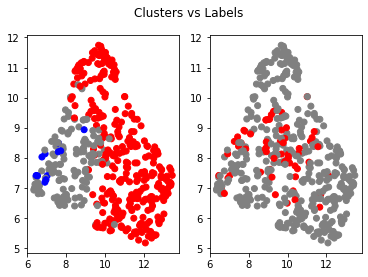

qval tensor([ 786.7526, 1311.5187,  151.7287], grad_fn=<SumBackward1>)
Cluster Counts [ 681 1513   56]

[  0/100] train_loss: 0.729 valid_loss: 0.748 valid_F1: 0.256 valid_AUC: 0.579 valid_Feature_p: 0.066 valid_MIFD: 0.534 valid_Silhouette: 0.255 Complexity Term: 0.000
Epoch: 00 | Loss: 3.734 | KM Loss: 59.261 | Classification Loss: 4.105 | Cluster Balance Loss: 41.162
Epoch: 01 | Loss: 3.648 | KM Loss: 53.562 | Classification Loss: 2.922 | Cluster Balance Loss: 38.283
Training data


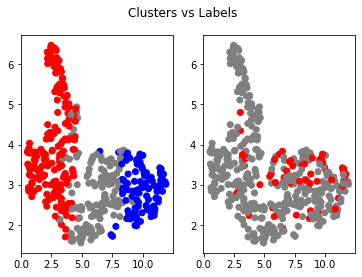

qval tensor([803.3606, 933.9197, 512.7197], grad_fn=<SumBackward1>)
Cluster Counts [785 867 598]

[  2/100] train_loss: 0.408 valid_loss: 0.458 valid_F1: 0.000 valid_AUC: 0.411 valid_Feature_p: 0.146 valid_MIFD: 0.517 valid_Silhouette: 0.216 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 02 | Loss: 1.126 | KM Loss: 47.693 | Classification Loss: 2.804 | Cluster Balance Loss: 36.843
Epoch: 03 | Loss: 0.674 | KM Loss: 46.722 | Classification Loss: 2.769 | Cluster Balance Loss: 36.719
Training data


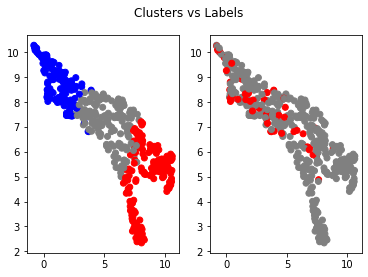

qval tensor([804.1426, 849.2943, 596.5631], grad_fn=<SumBackward1>)
Cluster Counts [814 727 709]

[  4/100] train_loss: 0.369 valid_loss: 0.380 valid_F1: 0.000 valid_AUC: 0.399 valid_Feature_p: 0.130 valid_MIFD: 0.516 valid_Silhouette: 0.230 Complexity Term: 0.000
EarlyStopping counter: 2 out of 7
Epoch: 04 | Loss: 1.225 | KM Loss: 47.189 | Classification Loss: 2.617 | Cluster Balance Loss: 36.619
Epoch: 05 | Loss: 0.994 | KM Loss: 46.527 | Classification Loss: 2.442 | Cluster Balance Loss: 36.559
Training data


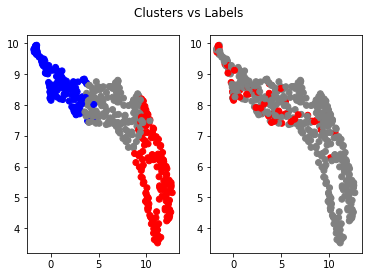

qval tensor([791.1652, 850.0118, 608.8231], grad_fn=<SumBackward1>)
Cluster Counts [778 737 735]

[  6/100] train_loss: 0.341 valid_loss: 0.341 valid_F1: 0.059 valid_AUC: 0.565 valid_Feature_p: 0.129 valid_MIFD: 0.519 valid_Silhouette: 0.277 Complexity Term: 0.000
EarlyStopping counter: 3 out of 7
Epoch: 06 | Loss: 1.347 | KM Loss: 47.272 | Classification Loss: 2.443 | Cluster Balance Loss: 36.595
Epoch: 07 | Loss: 1.176 | KM Loss: 46.768 | Classification Loss: 2.350 | Cluster Balance Loss: 36.545
Training data


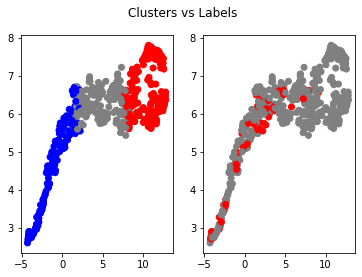

qval tensor([782.0427, 837.2548, 630.7026], grad_fn=<SumBackward1>)
Cluster Counts [760 729 761]

[  8/100] train_loss: 0.290 valid_loss: 0.306 valid_F1: 0.321 valid_AUC: 0.750 valid_Feature_p: 0.125 valid_MIFD: 0.515 valid_Silhouette: 0.307 Complexity Term: 0.000
Epoch: 08 | Loss: 1.372 | KM Loss: 47.019 | Classification Loss: 2.294 | Cluster Balance Loss: 36.561
Epoch: 09 | Loss: 1.244 | KM Loss: 46.891 | Classification Loss: 2.294 | Cluster Balance Loss: 36.570
Training data


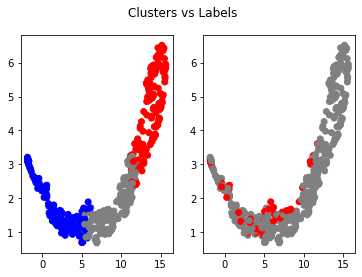

qval tensor([787.6238, 805.6428, 656.7333], grad_fn=<SumBackward1>)
Cluster Counts [766 693 791]

[ 10/100] train_loss: 0.290 valid_loss: 0.315 valid_F1: 0.512 valid_AUC: 0.796 valid_Feature_p: 0.122 valid_MIFD: 0.523 valid_Silhouette: 0.319 Complexity Term: 0.000
Epoch: 10 | Loss: 1.376 | KM Loss: 47.065 | Classification Loss: 2.182 | Cluster Balance Loss: 36.540
Epoch: 11 | Loss: 1.372 | KM Loss: 46.834 | Classification Loss: 2.085 | Cluster Balance Loss: 36.546
Training data


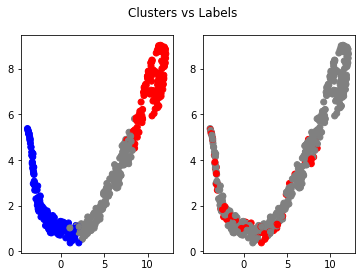

qval tensor([800.5172, 794.4272, 655.0556], grad_fn=<SumBackward1>)
Cluster Counts [787 667 796]

[ 12/100] train_loss: 0.261 valid_loss: 0.317 valid_F1: 0.344 valid_AUC: 0.720 valid_Feature_p: 0.126 valid_MIFD: 0.523 valid_Silhouette: 0.329 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 12 | Loss: 2.554 | KM Loss: 48.586 | Classification Loss: 1.986 | Cluster Balance Loss: 36.533
Epoch: 13 | Loss: 2.196 | KM Loss: 48.612 | Classification Loss: 2.104 | Cluster Balance Loss: 36.600
Training data


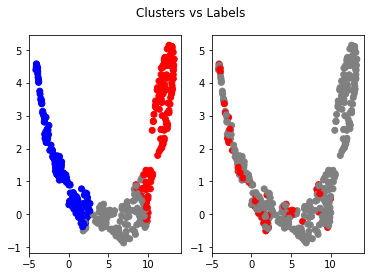

qval tensor([783.6667, 853.8795, 612.4538], grad_fn=<SumBackward1>)
Cluster Counts [746 691 813]

[ 14/100] train_loss: 0.275 valid_loss: 0.308 valid_F1: 0.289 valid_AUC: 0.846 valid_Feature_p: 0.118 valid_MIFD: 0.521 valid_Silhouette: 0.333 Complexity Term: 0.000
Epoch: 14 | Loss: 1.615 | KM Loss: 46.832 | Classification Loss: 1.642 | Cluster Balance Loss: 36.536
Epoch: 15 | Loss: 0.659 | KM Loss: 45.548 | Classification Loss: 1.825 | Cluster Balance Loss: 36.558
Training data


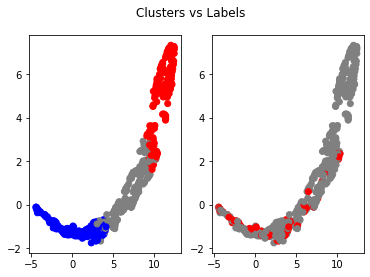

qval tensor([801.3746, 811.5222, 637.1030], grad_fn=<SumBackward1>)
Cluster Counts [773 688 789]

[ 16/100] train_loss: 0.259 valid_loss: 0.323 valid_F1: 0.392 valid_AUC: 0.655 valid_Feature_p: 0.120 valid_MIFD: 0.533 valid_Silhouette: 0.332 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 16 | Loss: 1.695 | KM Loss: 47.087 | Classification Loss: 1.852 | Cluster Balance Loss: 36.535
Epoch: 17 | Loss: 1.425 | KM Loss: 46.828 | Classification Loss: 1.865 | Cluster Balance Loss: 36.565
Training data


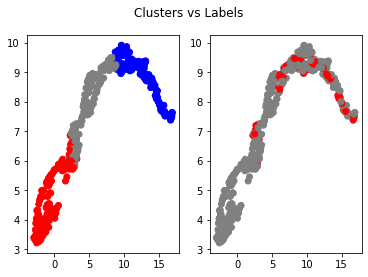

qval tensor([761.3947, 811.6770, 676.9284], grad_fn=<SumBackward1>)
Cluster Counts [746 686 818]

[ 18/100] train_loss: 0.302 valid_loss: 0.355 valid_F1: 0.518 valid_AUC: 0.856 valid_Feature_p: 0.127 valid_MIFD: 0.530 valid_Silhouette: 0.337 Complexity Term: 0.000
Epoch: 18 | Loss: 2.206 | KM Loss: 47.632 | Classification Loss: 1.596 | Cluster Balance Loss: 36.537
Epoch: 19 | Loss: 1.585 | KM Loss: 46.991 | Classification Loss: 1.730 | Cluster Balance Loss: 36.588
Training data


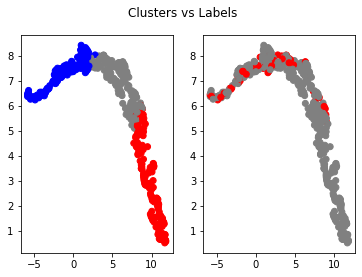

qval tensor([792.9827, 805.4836, 651.5336], grad_fn=<SumBackward1>)
Cluster Counts [755 692 803]

[ 20/100] train_loss: 0.231 valid_loss: 0.318 valid_F1: 0.390 valid_AUC: 0.619 valid_Feature_p: 0.118 valid_MIFD: 0.532 valid_Silhouette: 0.345 Complexity Term: 0.000
EarlyStopping counter: 1 out of 7
Epoch: 20 | Loss: 1.552 | KM Loss: 47.007 | Classification Loss: 1.823 | Cluster Balance Loss: 36.534
Epoch: 21 | Loss: 1.754 | KM Loss: 47.513 | Classification Loss: 1.724 | Cluster Balance Loss: 36.605
Training data


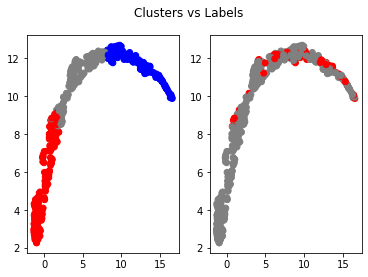

qval tensor([734.5399, 834.8446, 680.6156], grad_fn=<SumBackward1>)
Cluster Counts [717 737 796]

[ 22/100] train_loss: 0.255 valid_loss: 0.335 valid_F1: 0.531 valid_AUC: 0.840 valid_Feature_p: 0.125 valid_MIFD: 0.534 valid_Silhouette: 0.357 Complexity Term: 0.000
EarlyStopping counter: 2 out of 7
Epoch: 22 | Loss: 2.190 | KM Loss: 47.993 | Classification Loss: 1.567 | Cluster Balance Loss: 36.523
Epoch: 23 | Loss: 1.927 | KM Loss: 47.757 | Classification Loss: 1.493 | Cluster Balance Loss: 36.572
Training data


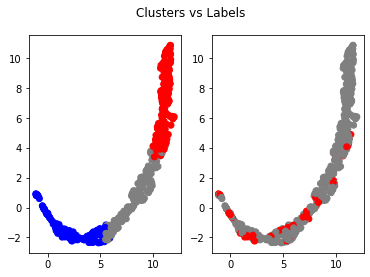

qval tensor([807.5269, 852.3630, 590.1101], grad_fn=<SumBackward1>)
Cluster Counts [776 749 725]

[ 24/100] train_loss: 0.258 valid_loss: 0.395 valid_F1: 0.233 valid_AUC: 0.680 valid_Feature_p: 0.130 valid_MIFD: 0.532 valid_Silhouette: 0.377 Complexity Term: 0.000
EarlyStopping counter: 3 out of 7
Epoch: 24 | Loss: 2.046 | KM Loss: 48.250 | Classification Loss: 1.505 | Cluster Balance Loss: 36.569
Epoch: 25 | Loss: 2.349 | KM Loss: 48.959 | Classification Loss: 1.498 | Cluster Balance Loss: 36.560
Training data


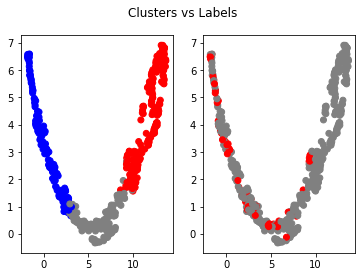

qval tensor([722.6855, 883.7406, 643.5740], grad_fn=<SumBackward1>)
Cluster Counts [719 797 734]

[ 26/100] train_loss: 0.223 valid_loss: 0.328 valid_F1: 0.520 valid_AUC: 0.851 valid_Feature_p: 0.105 valid_MIFD: 0.536 valid_Silhouette: 0.383 Complexity Term: 0.000
EarlyStopping counter: 4 out of 7
Epoch: 26 | Loss: 2.250 | KM Loss: 49.622 | Classification Loss: 1.468 | Cluster Balance Loss: 36.571
Epoch: 27 | Loss: 1.732 | KM Loss: 48.536 | Classification Loss: 1.560 | Cluster Balance Loss: 36.586
Training data


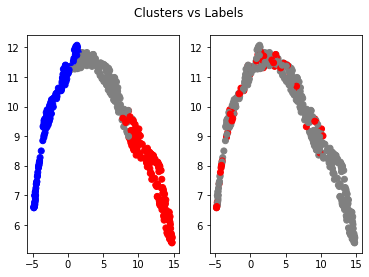

qval tensor([806.8646, 901.4690, 541.6663], grad_fn=<SumBackward1>)
Cluster Counts [803 749 698]

[ 28/100] train_loss: 0.303 valid_loss: 0.456 valid_F1: 0.140 valid_AUC: 0.614 valid_Feature_p: 0.114 valid_MIFD: 0.527 valid_Silhouette: 0.395 Complexity Term: 0.000
EarlyStopping counter: 5 out of 7
Epoch: 28 | Loss: 2.854 | KM Loss: 50.605 | Classification Loss: 1.376 | Cluster Balance Loss: 36.709
Epoch: 29 | Loss: 2.369 | KM Loss: 49.320 | Classification Loss: 1.453 | Cluster Balance Loss: 36.609
Training data


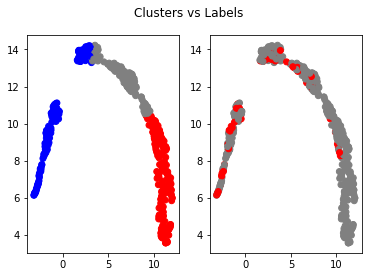

qval tensor([701.4404, 889.5267, 659.0327], grad_fn=<SumBackward1>)
Cluster Counts [657 824 769]

[ 30/100] train_loss: 0.294 valid_loss: 0.342 valid_F1: 0.529 valid_AUC: 0.832 valid_Feature_p: 0.090 valid_MIFD: 0.528 valid_Silhouette: 0.393 Complexity Term: 0.000
EarlyStopping counter: 6 out of 7
Epoch: 30 | Loss: 1.851 | KM Loss: 49.044 | Classification Loss: 1.639 | Cluster Balance Loss: 36.579
Epoch: 31 | Loss: 2.113 | KM Loss: 48.149 | Classification Loss: 1.279 | Cluster Balance Loss: 36.615
Training data


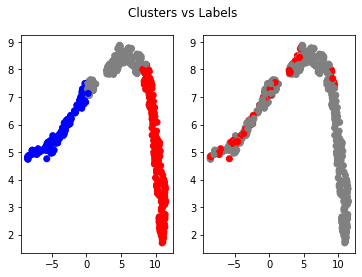

qval tensor([759.5764, 885.7963, 604.6272], grad_fn=<SumBackward1>)
Cluster Counts [724 767 759]

[ 32/100] train_loss: 0.193 valid_loss: 0.327 valid_F1: 0.384 valid_AUC: 0.840 valid_Feature_p: 0.087 valid_MIFD: 0.531 valid_Silhouette: 0.388 Complexity Term: 0.000
EarlyStopping counter: 7 out of 7

####################################################################################

Training Local Networks
Loading Best model with score:  [0.5180722891566265, 0.8564475524475524]

[ 32/100] train_loss: 0.166 valid_loss: 0.332 valid_F1: 0.387 valid_AUC: 0.826 valid_Sil: 0.337

[ 32/100] train_loss: 0.158 valid_loss: 0.303 valid_F1: 0.453 valid_AUC: 0.840 valid_Sil: 0.337

[ 32/100] train_loss: 0.156 valid_loss: 0.300 valid_F1: 0.483 valid_AUC: 0.845 valid_Sil: 0.337

[ 32/100] train_loss: 0.153 valid_loss: 0.308 valid_F1: 0.470 valid_AUC: 0.835 valid_Sil: 0.337
EarlyStopping counter: 1 out of 7

[ 32/100] train_loss: 0.152 valid_loss: 0.305 valid_F1: 0.501 valid_AUC: 0.838 valid_Sil: 0.33

In [6]:
####################################################################################
####################################################################################
####################################################################################
################################### Initialiation ##################################
####################################################################################
####################################################################################
####################################################################################

f1_scores, auc_scores, acc_scores , sil_scores, mifd_scores, nhfd_scores, w_nhfd_scores = [], [], [], [], [], [], []

# to track the training loss as the model trains
train_losses, e_train_losses = [], []
test_losses, e_test_losses, local_sum_test_losses = [], [], []
model_complexity = []

if args.ablation == "beta":
    iter_array = betas
    iteration_name = "Beta"

elif args.ablation == "gamma":
    iter_array = gammas
    iteration_name = "Gamma"

elif args.ablation == "delta":
    iter_array = deltas
    iteration_name = "Delta"

elif args.ablation == "k":
    iter_array = ks
    iteration_name = "K"

else:
    iter_array = range(1)
    iteration_name = "Run"

for r in range(len(iter_array)):
    if args.verbose == 'False':
        blockPrint()

    print(iteration_name, ":", iter_array[r])

    if args.ablation == "beta":
        args.beta = iter_array[r]

    elif args.ablation == "gamma":
        args.gamma = iter_array[r]

    elif args.ablation == "delta":
        args.delta = iter_array[r]

    elif args.ablation == "k":
        args.n_clusters = iter_array[r]

    suffix = base_suffix + "_" + iteration_name + "_" + str(iter_array[r])
    model = MultiHeadIDEC(
            n_enc_1=128,
            n_enc_2=64,
            n_enc_3=32,
            n_dec_1=32,
            n_dec_2=64,
            n_dec_3=128,
            args=args).to(args.device)

    model.pretrain(train_loader, args.pretrain_path)

    optimizer = Adam(model.parameters(), lr=args.lr)

    # cluster parameter initiate
    device = args.device
    y = y_train
    x_bar, hidden = model.ae(torch.Tensor(X_train).to(args.device))

    kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
    cluster_indices = kmeans.fit_predict(hidden.data.cpu().numpy())
    original_cluster_centers = kmeans.cluster_centers_
    model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)

    for i in range(args.n_clusters):
        cluster_idx = np.where(cluster_indices == i)[0]
        cluster_idx_p = np.where(y[cluster_idx] == 1)[0]
        cluster_idx_n = np.where(y[cluster_idx] == 0)[0]
        hidden_p = hidden[cluster_idx][cluster_idx_p]
        hidden_n = hidden[cluster_idx][cluster_idx_n]
        
        model.p_cluster_layer.data[i,:] = torch.mean(hidden_p, axis=0)
        model.n_cluster_layer.data[i,:] = torch.mean(hidden_n, axis=0)

    criterion = nn.CrossEntropyLoss(reduction='none')


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################## Clustering Step #################################
    ####################################################################################
    ####################################################################################
    ####################################################################################


    print("Starting Training")
    model.train()
    N_EPOCHS = args.n_epochs
    es = EarlyStoppingCAC(dataset=suffix)

    for epoch in range(N_EPOCHS):
        # beta = args.beta*(epoch*0.1)/(1+epoch*0.1)
        beta = args.beta
        # gamma = args.gamma - args.gamma*(epoch*0.1)/(1+epoch*0.1)
        gamma = args.gamma
        delta = args.delta
        eta = args.eta
        if epoch % args.log_interval == 0:
            plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)
            model.ae.eval() # prep model for evaluation
            for j in range(model.n_clusters):
                model.classifiers[j][0].eval()

            z_train, _, q_train = model(torch.Tensor(X_train).to(args.device), output="decoded")
            q_train, q_train_p, q_train_n = q_train
            p_train = target_distribution(q_train.detach())

            # evaluate clustering performance
            cluster_indices = q_train.detach().cpu().numpy().argmax(1)
            preds = torch.zeros((len(z_train), 2))

            # Calculate Training Metrics
            nmi, acc, ari = 0, 0, 0
            train_loss = 0
            B = []

            for j in range(model.n_clusters):
                cluster_idx = np.where(cluster_indices == j)[0]
                X_cluster = z_train[cluster_idx]
                y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

                # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)
                cluster_preds = model.classifiers[j][0](X_cluster)
                train_loss += torch.sum(criterion(cluster_preds, y_cluster))

            train_loss /= len(z_train)
            # Evaluate model on Validation dataset
            qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
            q_val = qs[0]
            cluster_ids = torch.argmax(q_val, axis=1)
            preds = torch.zeros((len(z_val), 2))

            # Weighted predictions
            if args.attention == False:
                for j in range(model.n_clusters):
                    cluster_id = np.where(cluster_ids == j)[0]
                    X_cluster = z_val[cluster_id]
                    cluster_preds_val = model.classifiers[j][0](X_cluster)
                    preds[cluster_id,:] = cluster_preds_val

            else:
                for j in range(model.n_clusters):
                    X_cluster = z_val
                    cluster_preds = model.classifiers[j][0](X_cluster)
                    preds[:,0] += q_val[:,j]*cluster_preds[:,0]
                    preds[:,1] += q_val[:,j]*cluster_preds[:,1]

            print("qval", torch.sum(q_val, axis=0))
            print("Cluster Counts", np.bincount(cluster_ids))
            # print("KL div", torch.kl_div(torch.sum(q_val, axis=0),\
            #                         torch.ones(args.n_clusters)/args.n_clusters))

            # Classification Matrics
            val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
            val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())

            # Clustering Metrics
            val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids.data.cpu().numpy(), metric='euclidean')
            val_feature_diff = calculate_nhfd(X_val, cluster_ids)
            val_MIFD = calculate_MIFD(X_val, cluster_ids)
            complexity_term = 0
            # complexity_term  = calculate_bound(model, B, len(z_train))

            val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))

            # # record validation loss
            # valid_losses.append(loss.item())

            # # calculate average loss over an epoch
            # valid_loss = np.average(valid_losses)
            # avg_valid_losses.append(valid_loss)

            epoch_len = len(str(N_EPOCHS))

            print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.3f} ' +
                         f'valid_loss: {val_loss:.3f} '  +
                         f'valid_F1: {val_f1:.3f} '  +
                         f'valid_AUC: {val_auc:.3f} ' + 
                         f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                         f'valid_MIFD: {val_MIFD:.3f} ' + 
                         f'valid_Silhouette: {val_sil:.3f} ' + 
                         f'Complexity Term: {complexity_term:.3f}')

            print(print_msg)

            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            es([val_f1, val_auc], model)
            if es.early_stop == True:
                break

        # Normal Training
        epoch_loss = 0
        epoch_balance_loss = 0
        epoch_class_loss = 0
        epoch_km_loss = 0
        
        model.ae.train() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].train()

        for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            idx = idx.to(device)

            X_latents, x_bar, q_batch = model(x_batch)
            q_batch = q_batch[0]
            reconstr_loss = F.mse_loss(x_bar, x_batch)

            classifier_labels = np.zeros(len(idx))
            sub_epochs = min(10, 1 + int(epoch/5))

            if args.attention == False:
                classifier_labels = np.argmax(q_batch.detach().cpu().numpy(), axis=1)

            for _ in range(sub_epochs):
                # Choose classifier for a point probabilistically
                if args.attention == True:
                    for j in range(len(idx)):
                        classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())

                for k in range(args.n_clusters):
                    idx_cluster = np.where(classifier_labels == k)[0]
                    X_cluster = X_latents[idx_cluster]
                    y_cluster = y_batch[idx_cluster]

                    classifier_k, optimizer_k = model.classifiers[k]
                    # Do not backprop the error to encoder
                    y_pred_cluster = classifier_k(X_cluster.detach())
                    cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                    optimizer_k.zero_grad()
                    cluster_loss.backward(retain_graph=True)
                    optimizer_k.step()

            # Back propagate the error corresponding to last clustering
            class_loss = torch.tensor(0.).to(args.device)
            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                y_pred_cluster = classifier_k(X_cluster)
                class_loss += torch.sum(q_batch[idx_cluster,k]*criterion(y_pred_cluster, y_cluster))

            class_loss /= len(X_latents)
            delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
            delta_mu_p = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
            delta_mu_n = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)

            cluster_id = torch.argmax(q_batch, 1)
            # print(np.bincount(cluster_id.cpu().numpy()))

            positive_class_dist = 0
            negative_class_dist = 0
            km_loss             = 0
            class_sep_loss      = 0

            # for j in range(args.n_clusters):
            #     pts_index = np.where(cluster_id == j)[0]
            #     cluster_pts = X_latents[pts_index]
            #     n_class_index = np.where(y_batch[pts_index] == 0)[0]
            #     p_class_index = np.where(y_batch[pts_index] == 1)[0]

            #     n_class = cluster_pts[n_class_index]
            #     p_class = cluster_pts[p_class_index]

            #     delta_mu_p[j,:] = p_class.sum(axis=0)/(1+len(p_class))
            #     delta_mu_n[j,:] = n_class.sum(axis=0)/(1+len(n_class))
            #     delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))

            #     s1 = torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/(1+len(p_class))
            #     s2 = torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/(1+len(n_class))
            #     m12 = torch.linalg.vector_norm(model.p_cluster_layer[j] - model.n_cluster_layer[j])

            #     class_sep_loss += (s1+s2)/m12
            #     km_loss += torch.linalg.vector_norm(X_latents[pts_index] - model.cluster_layer[j])/(1+len(cluster_pts))

            q_batch = source_distribution(X_latents, model.cluster_layer, alpha=model.alpha)
            P = torch.sum(torch.nn.Softmax(dim=1)(10*q_batch), axis=0)
            P = P/P.sum()
            Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

            if args.cluster_balance == "kl":
                cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
            else:
                # cluster_balance_loss = torch.linalg.vector_norm(torch.sqrt(P) - torch.sqrt(Q))
                cluster_balance_loss = torch.linalg.vector_norm(torch.log(P) + torch.log(1-P))
                # cluster_balance_loss = torch.linalg.vector_norm(1/P + 1/(1-P))

            km_loss = F.kl_div(q_batch.log(), p_train[idx], reduction='batchmean')

            loss = reconstr_loss
            if args.beta != 0:
                loss += beta*km_loss
            if args.gamma != 0:
                loss += gamma*class_loss
            if args.delta != 0:
                loss += delta*cluster_balance_loss
            if args.eta != 0:
                loss += eta*class_sep_loss

            epoch_loss += loss
            epoch_class_loss += class_loss
            epoch_balance_loss += cluster_balance_loss
            epoch_km_loss += km_loss
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            # Update the positive and negative centroids
            # for j in range(args.n_clusters):
            #     pts_index = np.where(cluster_id == j)[0]
            #     n_class_index = np.where(y[pts_index] == 0)[0]
            #     p_class_index = np.where(y[pts_index] == 1)[0]

            #     N  = len(pts_index)
            #     Np = len(p_class_index)
            #     Nn = len(n_class_index)
            #     model.p_cluster_layer.data[j:] -= (1/(100+Np))*delta_mu_p[j:]
            #     model.n_cluster_layer.data[j:] -= (1/(100+Nn))*delta_mu_n[j:]
            #     model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

        print('Epoch: {:02d} | Loss: {:.3f} | KM Loss: {:.3f} | Classification Loss: {:.3f} | Cluster Balance Loss: {:.3f}'.format(
                    epoch, epoch_km_loss, epoch_loss, epoch_class_loss, epoch_balance_loss))

    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Local Training #################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    print("\n####################################################################################\n")
    print("Training Local Networks")
    model = es.load_checkpoint(model)

    es = EarlyStoppingCAC(dataset=suffix)

    qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
    q_train = qs[0]
    cluster_id_train = torch.argmax(q_train, axis=1)

    # X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
    X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

    train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
        batch_size=1024, shuffle=False)

    B = []

    # plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
    #      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

    # Post clustering training
    for e in range(N_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        acc = 0

        # model.ae.train() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].train()

        # Full training of local networks
        for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
            # torch.autograd.set_detect_anomaly(True)

            classifier_labels = np.zeros(len(X_latents))
            # Choose classifier for a point probabilistically
            if args.attention == True:
                for j in range(len(X_latents)):
                    classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
            else:
                classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()
        
        # model.ae.eval() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].eval()

        train_preds = torch.zeros((len(z_train), 2))
        train_loss = 0

        # Weighted predictions
        q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
        q_train = q_train[0]
        cluster_ids_train = torch.argmax(q_train, axis=1)
        
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids_train == j)[0]
            X_cluster = z_train
            y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

            # Ensemble train loss
            cluster_preds = model.classifiers[j][0](X_cluster)
            train_preds[:,0] += q_train[:,j]*cluster_preds[:,0]
            train_preds[:,1] += q_train[:,j]*cluster_preds[:,1]

            X_cluster = z_train[cluster_id]
            cluster_preds = model.classifiers[j][0](X_cluster)
            train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
            # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


        train_loss /= len(z_train)
        e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

        # Evaluate model on Validation set
        qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
        q_val = qs[0]
        cluster_ids_val = torch.argmax(q_val, axis=1)
        preds = torch.zeros((len(z_val), 2))

        # Weighted predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids_val == j)[0]
            X_cluster = z_val
            cluster_preds = model.classifiers[j][0](X_cluster)
            preds[:,0] += q_val[:,j]*cluster_preds[:,0]
            preds[:,1] += q_val[:,j]*cluster_preds[:,1]

        val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
        val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
        val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

        val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
        # record validation loss
        # valid_losses.append(loss.item())

        # calculate average loss over an epoch
        # valid_loss = np.average(valid_losses)
        # avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(N_EPOCHS))
        
        print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'valid_loss: {val_loss:.3f} '  +
                     f'valid_F1: {val_f1:.3f} '  +
                     f'valid_AUC: {val_auc:.3f} ' +
                     f'valid_Sil: {val_sil:.3f}')
        
        print(print_msg)
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        es([val_f1, val_auc], model)
        if es.early_stop == True:
            train_losses.append(train_loss.item())
            e_train_losses.append(e_train_loss.item())
            sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
            nhfd_scores.append(calculate_nhfd(X_train,  cluster_ids_train))
            mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
            # model_complexity.append(calculate_bound(model, B, len(z_train)))
            break


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Testing Perf. ##################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

    # Load best model trained from local training phase
    model = es.load_checkpoint(model)

    # # Evaluate model on Test dataset
    qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
    q_test = qs[0]
    cluster_ids = torch.argmax(q_test, axis=1)
    # cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
    test_preds_e = torch.zeros((len(z_test), 2))

    test_loss = 0
    e_test_loss = 0
    local_sum_loss = 0

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_test
        cluster_test_preds = model.classifiers[j][0](X_cluster)
        test_preds_e[:,0] += q_test[:,j]*cluster_test_preds[:,0]
        test_preds_e[:,1] += q_test[:,j]*cluster_test_preds[:,1]
    
    e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
    e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
    e_test_auc = roc_auc_score(y_test, test_preds_e[:,1].detach().numpy())
    e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
    e_test_nhfd = calculate_nhfd(X_test, cluster_ids)

    test_preds = torch.zeros((len(z_test), 2))

    # Hard local predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids == j)[0]
        X_cluster = z_test[cluster_id]
        y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
        cluster_test_preds = model.classifiers[j][0](X_cluster)
        test_preds[cluster_id,:] = cluster_test_preds
        local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))
    
    test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
    test_auc = roc_auc_score(y_test, test_preds[:,1].detach().numpy())
    test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
    test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
    local_sum_loss /= len(X_test)

    test_losses.append(test_loss.item())
    e_test_losses.append(e_test_loss.item())
    local_sum_test_losses.append(local_sum_loss.item())

    # enablePrint()
    print("Run #{}".format(r))

    print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

    print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
          ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

    print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
        ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

    print("\n")
    f1_scores.append(e_test_f1)
    auc_scores.append(e_test_auc)
    acc_scores.append(e_test_acc)

    ####################################################################################
    ####################################################################################
    ####################################################################################
    ################################### Feature Imp. ###################################
    ####################################################################################
    ####################################################################################
    ####################################################################################


    regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
    qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = qs[0]
    cluster_ids = torch.argmax(q_train, axis=1)
    train_preds_e = torch.zeros((len(z_train), 2))
    feature_importances = np.zeros((args.n_clusters, args.input_dim))

    # Weighted predictions
    for j in range(model.n_clusters):
        X_cluster = z_train
        cluster_preds = model.classifiers[j][0](X_cluster)
        # print(q_test, cluster_preds[:,0])
        train_preds_e[:,0] += q_train[:,j]*cluster_preds[:,0]
        train_preds_e[:,1] += q_train[:,j]*cluster_preds[:,1]

    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids == j)[0]
        X_cluster = X_train[cluster_id]
        if args.attention == True:
            y_cluster = train_preds_e[cluster_id][:,1]
        else:
            y_cluster = train_preds[cluster_id][:,1]

        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
            best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
            feature_importances[j,:] = regs[j].feature_importances_
            # print("Cluster # ", j, "sized: ", len(cluster_id))
            # print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
            # print("=========================\n")

    feature_diff = 0
    cntr = 0
    for i in range(args.n_clusters):
        for j in range(args.n_clusters):
            if i > j:
                ci = torch.where(cluster_ids == i)[0]
                cj = torch.where(cluster_ids == j)[0]
                Xi = X_train[ci]
                Xj = X_train[cj]
                feature_diff += 100*sum(feature_importances[i]*feature_importances[j]*(ttest_ind(Xi, Xj, axis=0)[1] < 0.05))/args.input_dim
                # print("Cluster [{}, {}] p-value: ".format(i,j), feature_diff)
                cntr += 1

    # print("Average Feature Difference: ", feature_diff/cntr)
    if cntr == 0:
        w_nhfd_scores.append(0)
    else:
        w_nhfd_scores.append(feature_diff/cntr)


In [7]:
scales_X_train = scale.inverse_transform(X_train)
for i in range(n_clusters):
    ci = torch.where(cluster_ids == i)[0]
    Xi = scales_X_train[ci]
    

array([[ 1.88961874e+01,  5.97549759e+00,  2.68474024e+01, ...,
         2.75220518e+03,  1.09842335e+00,  2.09487278e+01],
       [ 1.38238648e+01,  4.97851860e+00,  1.02439022e+01, ...,
         1.92351936e+03,  6.23623221e-01,  1.24485415e+01],
       [ 6.72261327e+00,  5.97549759e+00,  7.47665215e+00, ...,
         2.40076877e+02, -1.53682510e-01,  1.87647569e+00],
       ...,
       [ 2.59974389e+01,  1.19573715e+01,  2.03904857e+01, ...,
         2.90107205e+03,  1.09842335e+00,  1.45913104e+01],
       [ 1.17949358e+01,  4.97851860e+00,  5.63181879e+00, ...,
         1.92351936e+03,  6.23623221e-01,  1.24485415e+01],
       [ 2.19395809e+01,  1.39513295e+01,  3.78698543e+00, ...,
         2.34282131e+03,  1.09842335e+00,  1.45913104e+01]])

In [21]:
column_names
scales_X_train[11]

array([ 1.28094003e+01,  9.90602640e-01,  2.31577357e+01,  8.71144448e+01,
        3.18935171e-03,  1.38228693e+02,  6.83840785e+01, -2.00112322e-04,
        3.67329035e-04, -8.47467481e-03,  6.23286800e+01,  1.50739613e+01,
        1.15462165e+02,  1.05054758e+02,  8.49333240e+01,  5.65817825e+01,
        6.48466908e+01,  9.60007917e+01,  2.85388101e+01,  9.66698340e+01,
        3.76924412e+01,  6.11511590e+01,  1.49963739e+01,  1.01716036e+02,
        9.81573606e+01,  8.23341342e+01,  5.58202296e+01,  7.38496989e+01,
        1.28637907e+02,  2.95219496e+01,  9.64712306e+01,  3.72216920e+01,
        4.44829772e+01,  1.40334377e+01,  1.00383299e+02,  7.61117650e+01,
        5.86091168e+01,  3.96885199e+01,  5.12034162e+01,  7.25689463e+01,
        1.89424207e+01,  9.49030358e+01,  3.61081417e+01,  8.34227346e+01,
        1.49965531e+01,  1.14212829e+02,  1.40080329e+02,  1.19120807e+02,
        8.97354791e+01,  9.38518470e+01,  1.37643416e+02,  3.73328206e+01,
        9.76158903e+01,  

## MIFD Cluster Analysis

In [50]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = scale.inverse_transform(X_train)

for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = calc_MI(Xi[:,c], Xj[:,c], 0)
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("MIFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C1| = ", len(ci), ", |C2| = ", len(cj))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))



MIFD Analysis of Clusters:  1,0
|C1| =  2154 , |C2| =  2270
MI = 16.133 ; Feature: Gender - C1 Mean: 0.593 , C2 Mean: 0.539
MI = 1.964 ; Feature: ALT_first - C1 Mean: 121.452 , C2 Mean: 108.433
MI = 1.299 ; Feature: TroponinI_first - C1 Mean: 6.831 , C2 Mean: 6.478
MI = 1.082 ; Feature: TroponinI_last - C1 Mean: 6.03 , C2 Mean: 5.735
MI = 0.727 ; Feature: CSRU - C1 Mean: 0.4 , C2 Mean: 0.191
MI = 0.696 ; Feature: SICU - C1 Mean: 0.241 , C2 Mean: 0.312
MI = 0.676 ; Feature: Cholesterol_first - C1 Mean: 158.404 , C2 Mean: 158.147
MI = 0.675 ; Feature: Cholesterol_last - C1 Mean: 158.395 , C2 Mean: 158.066
MI = 0.659 ; Feature: CCU - C1 Mean: 0.068 , C2 Mean: 0.142
MI = 0.548 ; Feature: NIDiasABP_median - C1 Mean: 54.639 , C2 Mean: 56.819


MIFD Analysis of Clusters:  2,0
|C1| =  2326 , |C2| =  2270
MI = 27.821 ; Feature: Gender - C1 Mean: 0.555 , C2 Mean: 0.539
MI = 0.899 ; Feature: CCU - C1 Mean: 0.216 , C2 Mean: 0.142
MI = 0.693 ; Feature: SICU - C1 Mean: 0.247 , C2 Mean: 0.312
MI = 

## NHFD

In [37]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi, Xj, axis=0, equal_var=True))[1]
            print(p_vals)
            for c in range(n_columns):
                mi_scores[joint_col_name][c] = np.round(np.exp(-p_vals[c]/0.05), 3)
                # print(column_names[c], ":", c_entropy)
            cntr += 1
            print("\n========\n")
            print(joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            print({column_names[k]: v for k, v in sorted_dict})
            for k, v in sorted_dict:
                print(column_names[k], "- C1:", np.mean(scaled_X_train[ci][:,k]), ", C2:", np.mean(scaled_X_train[cj][:,k]))

[1.50872882e-21 1.08520854e-08 4.87795650e-33 8.27890778e-01
 2.59661364e-04 1.96268825e-01 1.93260455e-01 1.26668402e-15
 7.72620028e-54 1.03823251e-07 4.97341386e-10 2.05797253e-03
 1.55482454e-41 3.32978544e-06 1.27762885e-12 4.62293031e-17
 2.08407835e-24 6.40521881e-21 2.05254018e-22 4.03877423e-06
 1.96972266e-04 1.36282804e-17 6.19381481e-67 6.08980645e-21
 1.83767965e-06 4.49746136e-28 3.41918013e-03 3.21809190e-07
 1.64743765e-10 1.14999354e-18 4.88985307e-01 1.47491967e-07
 2.98929107e-07 9.90206623e-03 8.61937601e-12 4.10868941e-03
 3.03172439e-05 4.65874527e-16 1.27007657e-21 8.17931006e-18
 8.86705028e-26 1.80289695e-03 5.04073045e-01 7.17379494e-16
 2.71594574e-43 1.23912347e-50 6.18518891e-15 3.33035992e-21
 5.46751211e-06 2.70121334e-11 1.52255297e-16 2.13875321e-25
 5.47578516e-04 1.13039170e-06 6.87389817e-19 6.15750522e-58
 2.16254146e-38 4.34244884e-09 3.98754128e-35 3.06422434e-11
 3.05658112e-21 5.65546969e-24 8.80215084e-39 4.28422440e-03
 1.36692181e-02 4.651879

## Local Training

In [29]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

es = EarlyStoppingCAC(dataset=suffix)

qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

B = []

# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

# Post clustering training
for e in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    # model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        if args.attention == True:
            for j in range(len(X_latents)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
        else:
            classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()

    # model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    train_preds = torch.zeros((len(z_train), 2))
    train_loss = 0

    # Weighted predictions
    q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = q_train[0]
    cluster_ids_train = torch.argmax(q_train, axis=1)

    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_train == j)[0]
        X_cluster = z_train
        y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

        # Ensemble train loss
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[:,0] += q_train[:,j]*cluster_preds[:,0]
        train_preds[:,1] += q_train[:,j]*cluster_preds[:,1]

        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
        # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


    train_loss /= len(z_train)
    e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

    # Evaluate model on Validation set
    qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
    q_val = qs[0]
    cluster_ids_val = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_val == j)[0]
        X_cluster = z_val
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_val[:,j]*cluster_preds[:,0]
        preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
    val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
    val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

    val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
    # record validation loss
    # valid_losses.append(loss.item())

    # calculate average loss over an epoch
    # valid_loss = np.average(valid_losses)
    # avg_valid_losses.append(valid_loss)

    epoch_len = len(str(N_EPOCHS))

    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'valid_loss: {val_loss:.3f} '  +
                 f'valid_F1: {val_f1:.3f} '  +
                 f'valid_AUC: {val_auc:.3f} ' +
                 f'valid_Sil: {val_sil:.3f}')

    print(print_msg)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([val_f1, val_auc], model)
    if es.early_stop == True:
        train_losses.append(train_loss.item())
        e_train_losses.append(e_train_loss.item())
        sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
        nhfd_scores.append(calculate_nhfd(X_train,  cluster_ids_train))
        mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
        # model_complexity.append(calculate_bound(model, B, len(z_train)))
        break



####################################################################################

Training Local Networks
Loading Best model with score:  [0.4225352112676057, 0.8639392607392608]

[ 22/100] train_loss: 306.277 valid_loss: 664.194 valid_F1: 0.469 valid_AUC: 0.865 valid_Sil: -0.010

[ 22/100] train_loss: 304.992 valid_loss: 671.371 valid_F1: 0.478 valid_AUC: 0.865 valid_Sil: -0.010

[ 22/100] train_loss: 304.820 valid_loss: 663.208 valid_F1: 0.470 valid_AUC: 0.865 valid_Sil: -0.010

[ 22/100] train_loss: 304.220 valid_loss: 662.152 valid_F1: 0.474 valid_AUC: 0.865 valid_Sil: -0.010

[ 22/100] train_loss: 303.008 valid_loss: 662.822 valid_F1: 0.480 valid_AUC: 0.865 valid_Sil: -0.010

[ 22/100] train_loss: 302.547 valid_loss: 663.330 valid_F1: 0.470 valid_AUC: 0.866 valid_Sil: -0.010

[ 22/100] train_loss: 302.707 valid_loss: 662.718 valid_F1: 0.484 valid_AUC: 0.866 valid_Sil: -0.010

[ 22/100] train_loss: 302.382 valid_loss: 663.487 valid_F1: 0.480 valid_AUC: 0.866 valid_Sil: -0.010


## Evaluating on Test Data

In [17]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)

# # Evaluate model on Test dataset
qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
q_test = qs[0]
cluster_ids = torch.argmax(q_test, axis=1)
# cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
test_preds_e = torch.zeros((len(z_test), 2))

test_loss = 0
e_test_loss = 0
local_sum_loss = 0

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds_e[:,0] += q_test[:,j]*cluster_test_preds[:,0]
    test_preds_e[:,1] += q_test[:,j]*cluster_test_preds[:,1]

e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_auc = roc_auc_score(y_test, test_preds_e[:,1].detach().numpy())
e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_nhfd = calculate_nhfd(X_test, cluster_ids)

test_preds = torch.zeros((len(z_test), 2))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds[cluster_id,:] = cluster_test_preds
    local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))

test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_auc = roc_auc_score(y_test, test_preds[:,1].detach().numpy())
test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
local_sum_loss /= len(X_test)

test_losses.append(test_loss.item())
e_test_losses.append(e_test_loss.item())
local_sum_test_losses.append(local_sum_loss.item())

# enablePrint()
# print("Run #{}".format(r))

print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
      ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

print("\n")
f1_scores.append(e_test_f1)
auc_scores.append(e_test_auc)
# acc_scores.append(e_test_acc)

print("\n")
print("Test F1: ", f1_scores)
print("Test AUC: ", auc_scores)

print("Sil scores: ", sil_scores)
print("NHFD: ", nhfd_scores)
print("MIFD: ", mifd_scores)

print("Train Loss: ", train_losses)
print("E-Train Loss: ", e_train_losses)

print("Test Loss: ", test_losses)
print("E-Test Loss: ", e_test_losses)
print("Local Test Loss: ", local_sum_test_losses)

print("Model Complexity: ", model_complexity)

# enablePrint()
print("Dataset\tk\tF1\tAUC\tACC\tSIL\tNHFD\tMIFD\tW-NHFD")

print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format\
    (args.dataset, args.n_clusters, np.average(f1_scores), np.average(auc_scores),\
    np.average(acc_scores), np.average(sil_scores), np.average(nhfd_scores),\
    np.average(mifd_scores), np.average(w_nhfd_scores)))

print("\n")


####################################################################################

Evaluating Test Data with k =  3  Attention =  True
Loading Best model with score:  [0.5, 0.8614633366633366]
Loss Metrics - Test Loss 939.536, E-Test Loss 946.010, Local Sum Test Loss 122.919
Clustering Metrics     - Acc 0.0000 , nmi 0.0000 , ari 0.0000, NHFD 0.074
Classification Metrics - Test F1 0.438, Test AUC 0.847, Test ACC 0.869 , E-Test F1 0.466, E-Test AUC 0.855, E-Test ACC 0.872




Test F1:  [0.46582984658298465]
Test AUC:  [0.855149271086176]
Sil scores:  [-0.01068612]
NHFD:  [0.3387557710957288]
MIFD:  [1.1413843291757655]
Train Loss:  [190.31500244140625]
E-Train Loss:  [1446.4432373046875]
Test Loss:  [939.5361328125]
E-Test Loss:  [946.0103149414062]
Local Test Loss:  [122.91876983642578]
Model Complexity:  []
Dataset	k	F1	AUC	ACC	SIL	NHFD	MIFD	W-NHFD
cic	3	0.466	0.855	nan	-0.011	0.339	1.141




/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### K-Means feature segregation ... 

In [7]:
from sklearn.metrics.cluster import adjusted_rand_score as ari_score
km = KMeans(n_clusters=args.n_clusters, n_init=20)
cluster_ids = torch.argmax(q_train, axis=1).data.cpu().numpy()
n_features = X_train.shape[1]
nmi_scores = {}
ari_scores = {}
nmi_sum = 0
ari_sum = 0
for feature in range(n_features):
    feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_
    nmi = nmi_score(feature_labels, cluster_ids)
    ari = ari_score(feature_labels, cluster_ids)
    nmi_sum += nmi
    ari_sum += ari
    nmi_scores[column_names[feature]] = np.round(nmi, 3)
    ari_scores[column_names[feature]] = np.round(ari, 3)

nmi_sum, ari_sum
{k: v for k, v in sorted(nmi_scores.items(), key=lambda item: item[1])}
{k: v for k, v in sorted(ari_scores.items(), key=lambda item: item[1])}

<ipython-input-7-97a7324fd4d1>:10: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_
<ipython-input-7-97a7324fd4d1>:10: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_
<ipython-input-7-97a7324fd4d1>:10: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_


{'Gender': 0.0,
 'Height': -0.0,
 'SaO2_last': 0.0,
 'SaO2_lowest': 0.0,
 'SaO2_highest': 0.0,
 'ALP_first': -0.0,
 'ALT_first': -0.0,
 'AST_first': -0.0,
 'Bilirubin_first': 0.0,
 'Mg_first': -0.0,
 'TroponinI_first': 0.0,
 'TroponinT_first': -0.0,
 'ALP_last': -0.0,
 'ALT_last': -0.0,
 'AST_last': -0.0,
 'Bilirubin_last': 0.0,
 'Platelets_last': 0.0,
 'TroponinI_last': 0.0,
 'TroponinT_last': 0.0,
 'Age': 0.001,
 'SaO2_first': 0.001,
 'RespRate_highest': 0.001,
 'SaO2_median': 0.001,
 'PaO2_last': 0.001,
 'MAP_first': 0.002,
 'Temp_first': 0.002,
 'NIDiasABP_last': 0.002,
 'Temp_lowest': 0.002,
 'NIDiasABP_highest': 0.002,
 'Cholesterol_first': 0.002,
 'Cholesterol_last': 0.002,
 'SICU': 0.003,
 'NIMAP_last': 0.003,
 'RespRate_lowest': 0.003,
 'Temp_highest': 0.003,
 'Platelets_first': 0.003,
 'FiO2_last': 0.003,
 'HCT_last': 0.003,
 'K_last': 0.003,
 'Lactate_last': 0.003,
 'Weight': 0.004,
 'GCS_first': 0.004,
 'NIDiasABP_first': 0.004,
 'RespRate_first': 0.004,
 'RespRate_last': 0

In [8]:
print(z_val, q_val)
q_labels = torch.argmax(q_val, axis=1).data.cpu().numpy()
km_labels = kmeans.fit_predict(z_val.data.cpu().numpy())
print(km_labels)
print(nmi_score(q_labels, km_labels))

tensor([[ -0.0470,   3.9581,  -0.6811,  ...,  -0.7307,   0.3996,  -0.1538],
        [  0.7745,  16.7383,  -4.1157,  ...,  -3.1421,   1.0533,  -1.2180],
        [  1.2878,  41.3400, -11.4000,  ...,  -8.2573,   3.4354,  -3.5407],
        ...,
        [ -0.3648,   8.5961,  -0.9250,  ...,  -2.0739,   1.2289,  -0.9856],
        [  0.6373,  14.0108,  -2.3756,  ...,  -2.7678,   1.3514,  -1.6754],
        [  0.9142,  17.9184,  -5.0957,  ...,  -3.3098,   0.9024,  -1.9583]],
       grad_fn=<AddmmBackward>) tensor([[0.0931, 0.0125, 0.8944],
        [0.2301, 0.6733, 0.0966],
        [0.2583, 0.5373, 0.2044],
        ...,
        [0.6842, 0.0289, 0.2869],
        [0.5611, 0.2685, 0.1704],
        [0.1116, 0.8357, 0.0527]], grad_fn=<TBackward>)
[0 2 1 ... 0 2 2]
0.5554603478570804


Training data


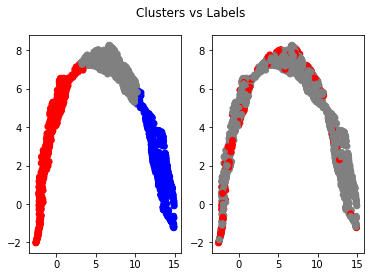

Cluster #  0 sized:  2199
[('GCS_last', 0.289), ('Age', 0.12), ('BUN_last', 0.101), ('NISysABP_lowest', 0.035), ('Weight_last', 0.034), ('GCS_first', 0.032), ('MechVentDuration', 0.027), ('Albumin_last', 0.024), ('pH_first', 0.022), ('CSRU', 0.02)]

Cluster #  1 sized:  2295
[('GCS_last', 0.178), ('BUN_last', 0.106), ('GCS_highest', 0.105), ('MechVentDuration', 0.073), ('Age', 0.072), ('CCU', 0.036), ('Length_of_stay', 0.028), ('GCS_median', 0.024), ('NISysABP_lowest', 0.023), ('Bilirubin_last', 0.023)]

Cluster #  2 sized:  2256
[('Age', 0.2), ('GCS_last', 0.188), ('GCS_first', 0.061), ('BUN_last', 0.04), ('MechVentDuration', 0.034), ('Albumin_first', 0.03), ('NISysABP_lowest', 0.027), ('RespRate_highest', 0.024), ('Glucose_last', 0.024), ('Weight_last', 0.021)]



In [9]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

plot(model, torch.FloatTensor(X_train).to(args.device), y_train, labels=None)

regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
q_train = qs[0]
cluster_ids = torch.argmax(q_train, axis=1)
preds_e = torch.zeros((len(z_train), 2))
feature_importances = np.zeros((args.n_clusters, args.input_dim))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_train
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_train[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_train[:,j]*cluster_preds[:,1]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_train[cluster_id]
    if args.attention == True:
        y_cluster = preds_e[cluster_id][:,1]
    else:
        y_cluster = preds[cluster_id][:,1]

    # Some test data might not belong to any cluster
    if len(cluster_id) > 0:
        regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
        best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
        feature_importances[j,:] = regs[j].feature_importances_
        print("Cluster # ", j, "sized: ", len(cluster_id))
        print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
        print("=========================\n")


## Baseline Model

In [10]:
f1_scores, auc_scores = [], []

for r in range(5):
    m = NNClassifier(args, input_dim=89)
    device = args.device

    N_EPOCHS = args.n_epochs
    es = EarlyStopping(dataset=args.dataset, path="./pretrained_model/checkpoint_base")

    kmeans = KMeans(n_clusters=args.n_classes, n_init=20)

    for e in range(1, N_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0
        m.train()
        nmi, acc, ari = 0, 0, 0

#         for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = torch.FloatTensor(X_train), torch.Tensor(y_train).type(torch.LongTensor)
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score(np.argmax(y_pred, axis=1), y_batch)
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()


        m.classifier.eval()
        val_pred = m(torch.FloatTensor(X_val).to(args.device))
        val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, torch.Tensor(y_val).type(torch.LongTensor))

        val_f1 = f1_score(torch.argmax(val_pred, axis=1), y_val)
        val_auc = roc_auc_score(y_val, val_pred[:,1].data.cpu().numpy())
        es([val_f1, val_auc], m)

        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
            f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
            f'Val F1: {val_f1:.3f} | Val Acc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

        if es.early_stop == True:
            break


    ###################################### Testing #####################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data")

    # Load best model trained from local training phase
    m = es.load_checkpoint(m)
    m.classifier.eval()
    test_pred = m.classifier(torch.FloatTensor(X_test))
    test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.Tensor(y_test).type(torch.LongTensor))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
    test_auc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())
    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    
    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
        f'Test F1: {test_f1:.3f} | Test Acc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')


#     reg = GradientBoostingRegressor(random_state=0)

#     reg.fit(X_test, y_test)
#     best_features = np.argsort(reg.feature_importances_)[::-1][:10]
#     print("Best Features ")
#     print(column_names[best_features])
#     print("=========================\n")
print(f1_scores, auc_scores)
print("Avg. Test F1 = {:.3f}, AUC = {:.3f}".format(np.average(f1_scores), np.average(auc_scores)))

NameError: name 'NNClassifier' is not defined